In [6]:
from helper import phys
import numpy as np
import pandas as pd
import astropy.io.ascii as asci
import scipy.optimize as op
import astropy.constants as const
from astropy.time import Time
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from astropy.table import Table
from collections import OrderedDict as odict
from allsn_info import get_at2019dge

import matplotlib
fs = 14
matplotlib.rcParams['font.size']=fs

### Prepare the data

In [20]:
result = get_at2019dge(colorplt=False)
lc = result['tb']
toff = 3.3

In [9]:
# # I do not think including SEDM photometry will be useful
lc = lc[lc.instrument!='P60+SEDM']
lcdet = lc.sort_values(by = ['mjd'])

In [10]:
dates = np.unique(lcdet["date"].values)

In [12]:
flags = np.ones(len(dates), dtype = int)
indlc = np.ones(len(lcdet), dtype = int)

In [13]:
for i in range(len(dates)):
    mydate = dates[i]
    ix = lcdet['date'].values == mydate
    lckeck = lcdet[ix]
    allwv = np.unique(lckeck['wave'].values)
    # we need at least three bands to fit a blackbody
    for j in range(15):
        if len(allwv)==j:
            flags[i] = j
            indlc[ix] = j

In [29]:
lcdet1 = lcdet[indlc>=3]
dates1 = dates[flags>=3]

lcdet2 = lcdet[indlc==2]
dates2 = dates[flags==2]

In [27]:
dates1.shape

(18,)

In [30]:
dates2

array(['2019 04 07', '2019 04 14', '2019 04 15', '2019 05 09',
       '2019 05 13'], dtype=object)

In [32]:
np.save('./helper/dates1.npy', dates1)
np.save('./helper/dates2.npy', dates2)
lcdet1.to_csv("./helper/lcdet.csv")
lcdet2.to_csv("./helper/lcdet_2bands.csv")

### Blackbody fit (with MCMC)

In [28]:
from helper.mcmcfit import main_bbrun

In [77]:
# main_bbrun()

Note that this is going to take some time. For easy reference I move the print out here below:

mydate = 2019 04 11, lgLbb_med = 42.20, Tbb_med = 11195.70, Rbb_med = 5386.35<br>
mydate = 2019 04 09, lgLbb_med = 42.43, Tbb_med = 15969.35, Rbb_med = 3480.25<br>
mydate = 2019 04 23, lgLbb_med = 41.52, Tbb_med = 6416.26, Rbb_med = 7545.84<br>
mydate = 2019 04 10, lgLbb_med = 42.28, Tbb_med = 12322.73, Rbb_med = 4921.88<br>
mydate = 2019 04 13, lgLbb_med = 41.92, Tbb_med = 8221.39, Rbb_med = 7271.79<br>
mydate = 2019 04 24, lgLbb_med = 41.49, Tbb_med = 6486.71, Rbb_med = 7092.27<br>
mydate = 2019 04 22, lgLbb_med = 41.61, Tbb_med = 6754.01, Rbb_med = 7486.37<br>
mydate = 2019 04 18, lgLbb_med = 41.72, Tbb_med = 6983.37, Rbb_med = 8019.87<br>
mydate = 2019 04 19, lgLbb_med = 41.74, Tbb_med = 7612.70, Rbb_med = 6864.61<br>
mydate = 2019 04 21, lgLbb_med = 41.65, Tbb_med = 7323.76, Rbb_med = 6701.98<br>
mydate = 2019 05 07, lgLbb_med = 40.86, Tbb_med = 5813.34, Rbb_med = 4250.36<br>
mydate = 2019 04 20, lgLbb_med = 41.66, Tbb_med = 6951.55, Rbb_med = 7491.94<br>
mydate = 2019 04 25, lgLbb_med = 41.45, Tbb_med = 6213.67, Rbb_med = 7379.88<br>
mydate = 2019 04 17, lgLbb_med = 41.79, Tbb_med = 7700.17, Rbb_med = 7122.43<br>
mydate = 2019 05 04, lgLbb_med = 41.01, Tbb_med = 5527.42, Rbb_med = 5588.31<br>
mydate = 2019 05 08, lgLbb_med = 40.90, Tbb_med = 5011.44, Rbb_med = 5954.40<br>
mydate = 2019 04 08, lgLbb_med = 42.66, Tbb_med = 23013.43, Rbb_med = 2176.12<br>
Pool map took 4639.9420 sec


Useful unix command: `find . ! -name "2019" -mtime +10 -exec rm {} \;`<br>

### Rough BB fit (without covariance)

In [36]:
from helper.mcmcfit import bb_nll
dates2 = np.load("./helper/dates2.npy")
lcdet2 = pd.read_csv("./helper/lcdet_2bands.csv")

### Construct SEDs

In [52]:
from helper.mcmcfit import planck_lambda, mylinear_fit

In [53]:
dates = np.hstack([dates1, dates2])
dates = dates[np.argsort(dates)]

<IPython.core.display.Javascript object>


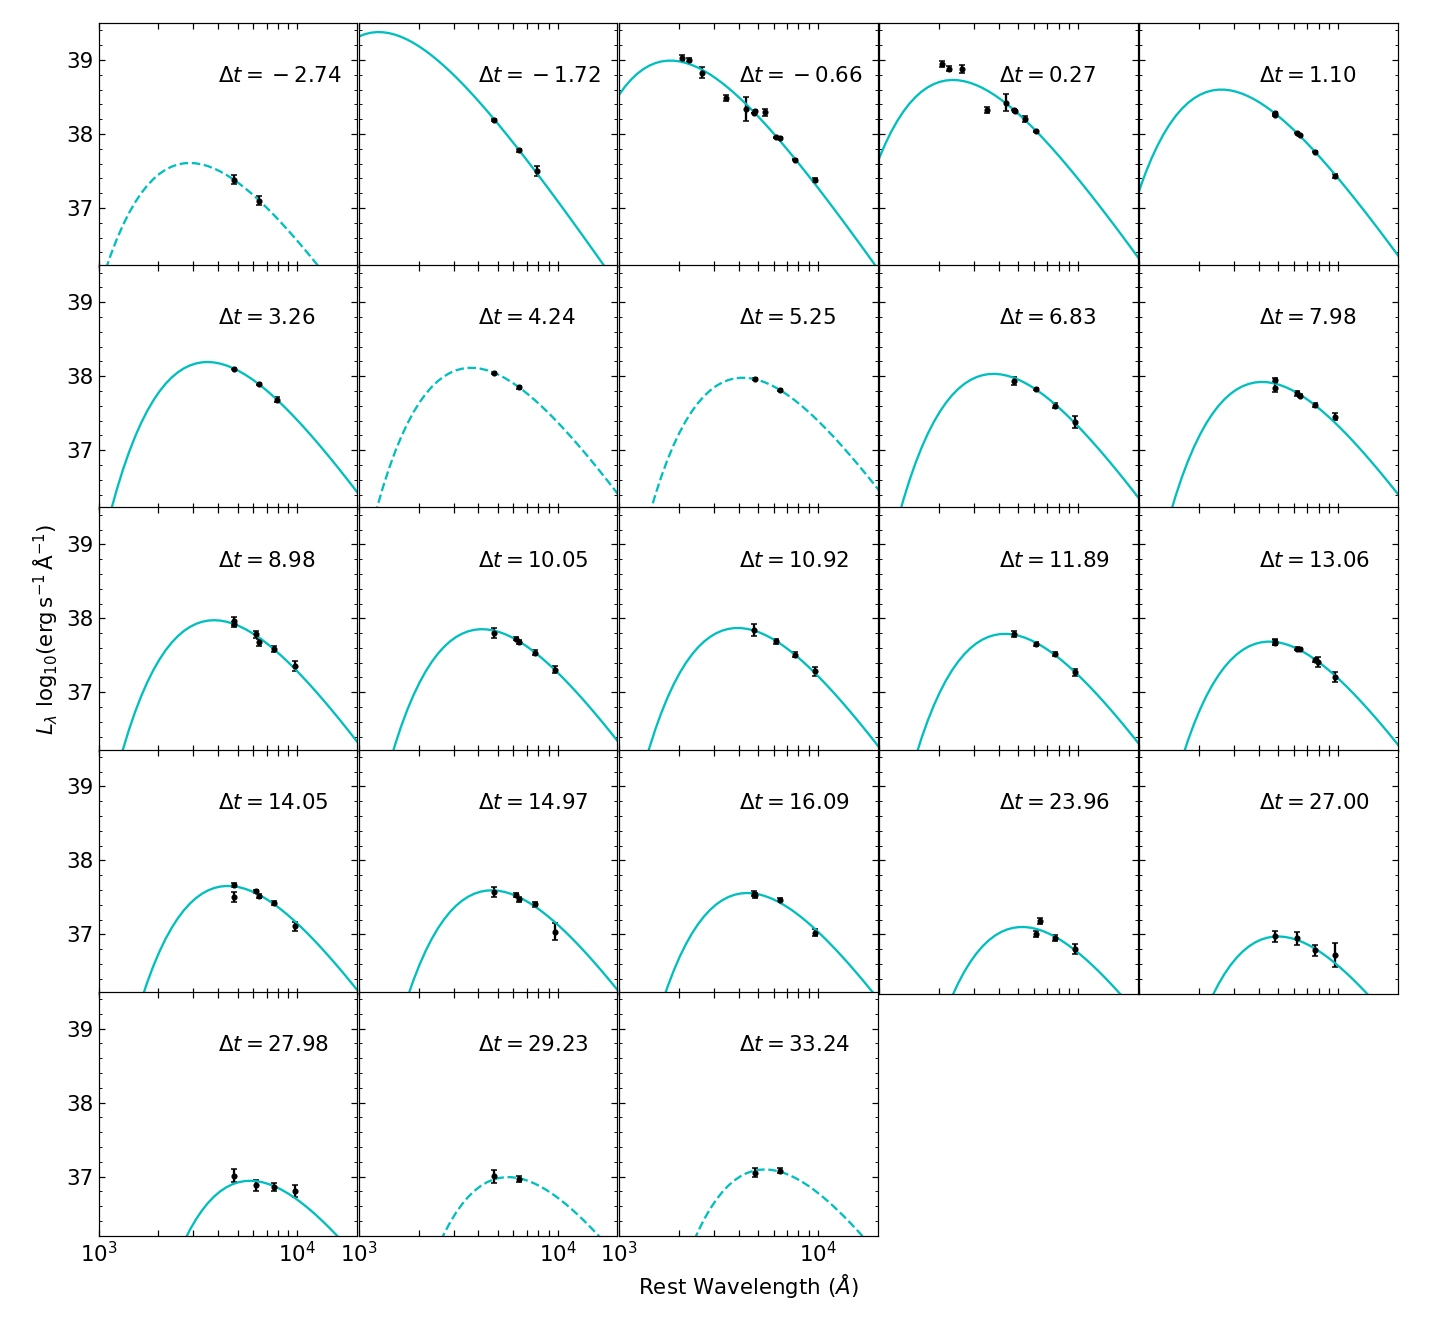

Assuming explosion epoch is 3.3 day before maximum. i.e., 0.56 day before first detection 


In [151]:
    result = get_at2019dge(color=False)
    t0jd = result['t_max']
    
    dates1 = np.load("./helper/dates1.npy")
    dates2 = np.load("./helper/dates2.npy")
    lcdet = pd.read_csv("./helper/lcdet.csv")
    lcdet2 = pd.read_csv("./helper/lcdet_2bands.csv")
    
    Tbbs = np.zeros(len(dates))
    Rbbs = np.zeros(len(dates))
    Lbbs = np.zeros(len(dates))
    lgLbbs = np.zeros(len(dates))
    
    Tbbs_unc = np.zeros(len(dates))
    Rbbs_unc = np.zeros(len(dates))
    Lbbs_unc = np.zeros(len(dates))
    lgLbbs_unc = np.zeros(len(dates))
    
    Tbbs_uncl = np.zeros(len(dates))
    Rbbs_uncl = np.zeros(len(dates))
    Lbbs_uncl = np.zeros(len(dates))
    lgLbbs_uncl = np.zeros(len(dates))
    
    Tbbs_uncr = np.zeros(len(dates))
    Rbbs_uncr = np.zeros(len(dates))
    Lbbs_uncr = np.zeros(len(dates))
    lgLbbs_uncr = np.zeros(len(dates))
    
    jds = np.zeros(len(dates))
    s = "_"
    nrow = 5
    ncol = 5
    
    fig, axes = plt.subplots(nrow, ncol, figsize=(13, 12), sharey=True, sharex=True)
    
    lamb = np.logspace(3, 4.5)
    
    for ind in range(len(dates2)):
        mydate = dates2[ind]
        i = np.where(dates == mydate)[0][0]
        ix = lcdet2['date'].values == mydate
        lckeck = lcdet2[ix]
        
        ii = i // ncol
        jj = i % ncol
        t = np.mean(lckeck['mjd'].values)
        jds[i] = t
        
        x = lckeck['wave'].values
        y = lckeck['Llambda'].values        
        yerr = lckeck['Llambda_unc'].values
        result = op.minimize(bb_nll, [8e+3, 6e+3],
                             method='Powell', args=(x, y, yerr))
        ml_guess = result["x"]
        Tbbs[i] = ml_guess[0]
        Rbbs[i] = ml_guess[1]
    
        Lbbs[i] = const.sigma_sb.cgs.value * Tbbs[i] **4 * 4 * np.pi * (Rbbs[i] * const.R_sun.cgs.value)**2
        lgLbbs[i] = np.log10(Lbbs[i])
        
        lgLlambdas = np.log10(y)
        lgLlambdas_unc = 1 / np.log(10) * yerr / y
                
        flux = planck_lambda(Tbbs[i], Rbbs[i], lamb)
        deltat = t - t0jd
        
        ax = axes[ii,jj]        
        ax.errorbar(x, lgLlambdas, lgLlambdas_unc, fmt='.k', capsize=2)
        ax.plot(lamb, np.log10(flux), color='c', linestyle = "--")
        ax.set_xlim(1000, 20000)
        ax.set_ylim(36.2, 39.5)
        ax.semilogx()
                
        if ii!=nrow-1:
            ax.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
            ax.set_xticklabels(['', '', '', '', '', '', '', '', '', ''])
        else:
            ax.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
            ax.set_xticklabels(['$10^3$', '', '', '', '', '', '', '', '', '$10^4$'])
                
        if deltat>0:
            ax.text(4000, 38.7, '$\Delta t=$%.2f'%deltat, color='k')
        else:
            ax.text(4000, 38.7, '$\Delta t=-$%.2f'%abs(deltat), color='k')
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(direction='in', axis='both', which = 'both', top=True, right=True)
        ax.tick_params(which='major', length=4)
        ax.tick_params(which='minor', length=2)
        
    
    for ind in range(len(dates1)):
        mydate = dates1[ind]
        i = np.where(dates == mydate)[0][0]
        filename = '../data/analysis/mcmcresult/'+s.join(mydate.split(' '))+'.txt'
        
        pars = np.loadtxt(filename)
        ix = lcdet['date'].values == mydate
        lckeck = lcdet[ix]
        nband = len(np.unique(lckeck['wave'].values))
            
        ii = i // ncol
        jj = i % ncol
        
        t = np.mean(lckeck['mjd'].values)
        jds[i] = t
        
        Lbbs[i] = pars[0][3]
        Lbbs_unc[i] = (pars[0][4]-pars[0][2])/2
        Lbbs_uncr[i] = pars[0][4]-pars[0][3]
        Lbbs_uncl[i] = pars[0][3]-pars[0][2]   
        
        lgLbbs[i] = np.log10(pars[0][3])
        lgLbbs_unc[i] = (np.log10(pars[0][4])-np.log10(pars[0][2]))/2
        lgLbbs_uncr[i] = np.log10(pars[0][4])-np.log10(pars[0][3])
        lgLbbs_uncl[i] = np.log10(pars[0][3])-np.log10(pars[0][2])
        
        Tbbs[i] = pars[1][3]
        Tbbs_unc[i] = (pars[1][4]-pars[1][2])/2
        Tbbs_uncr[i] = pars[1][4]-pars[1][3]
        Tbbs_uncl[i] = pars[1][3]-pars[1][2]
                
        Rbbs[i] = pars[2][3]
        Rbbs_unc[i] = (pars[2][4]-pars[2][2])/2
        Rbbs_uncr[i] = pars[2][4]-pars[2][3]
        Rbbs_uncl[i] = pars[2][3]-pars[2][2]            
            
        x = lckeck['wave'].values
        y = lckeck['Llambda'].values
        yerr = lckeck['Llambda_unc'].values
                
        lgLlambdas = np.log10(y)
        lgLlambdas_unc = 1 / np.log(10) * yerr / y
                
        flux = planck_lambda(Tbbs[i], Rbbs[i], lamb)
        deltat = t - t0jd
        ax = axes[ii,jj]        
        ax.errorbar(x, lgLlambdas, lgLlambdas_unc, fmt='.k', capsize=2)
        ax.plot(lamb, np.log10(flux), color='c')
        ax.set_xlim(1000, 20000)
        ax.set_ylim(36.2, 39.5)
        ax.semilogx()
                
        if ii!=nrow-1:
            ax.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
            ax.set_xticklabels(['', '', '', '', '', '', '', '', '', ''])
        else:
            ax.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
            ax.set_xticklabels(['$10^3$', '', '', '', '', '', '', '', '', '$10^4$'])
                
        if deltat>0:
            ax.text(4000, 38.7, '$\Delta t=$%.2f'%deltat, color='k')
        else:
            ax.text(4000, 38.7, '$\Delta t=-$%.2f'%abs(deltat), color='k')
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(direction='in', axis='both', which = 'both', top=True, right=True)
        ax.tick_params(which='major', length=4)
        ax.tick_params(which='minor', length=2)
        
    plt.tight_layout(rect = (0.03, 0.02, 1, 1), # left, bottom, right, top
                     h_pad=-0.09, w_pad=-1.25)
    axes[4,2].set_xlabel("Rest Wavelength"+' ('+r'$\AA$'+')')
    axes[2,0].set_ylabel(r'$L_{\lambda}$ log'+r'$_{10}\rm(erg\,s^{-1}\,\AA^{-1})$')
    
    axes[4,4].set_axis_off()
    axes[4,3].set_axis_off()
    plt.savefig("../paper/figures/seds.pdf")
    #plt.close()

    
    trf = jds-t0jd
    print ("Assuming explosion epoch is %.1f day before maximum. i.e., %.2f day before first detection "%(toff, trf[0] + toff))
    
    tb = Table(data = [trf, trf+toff, Lbbs, Lbbs_unc, Lbbs_uncr, Lbbs_uncl, 
                       lgLbbs, lgLbbs_unc, lgLbbs_uncr, lgLbbs_uncl, 
                       Tbbs, Tbbs_unc, Tbbs_uncr, Tbbs_uncl,
                       Rbbs, Rbbs_unc, Rbbs_uncr, Rbbs_uncl],
               names = ['phase', 't', 'Lbb', 'Lbb_unc', 'Lbb_uncr', 'Lbb_uncl', 
                        'lgLbb', 'lgLbb_unc', 'lgLbb_uncr', 'lgLbb_uncl',
                        'Tbb', 'Tbb_unc', 'Tbb_uncr', 'Tbb_uncl',
                        'Rbb', 'Rbb_unc', 'Rbb_uncr', 'Rbb_uncl'])
    tb.write('../data/otherSN/Yao2020/bbdata.csv',overwrite=True)

In [14]:
tb = pd.read_csv('../data/otherSN/Yao2020/bbdata.csv')
Tbbs = tb["Tbb"].values
Tbbs_uncl = tb["Tbb_uncl"].values
Tbbs_uncr = tb["Tbb_uncr"].values

Rbbs = tb["Rbb"].values
Rbbs_unc = tb["Rbb_unc"].values
Rbbs_uncl = tb["Rbb_uncl"].values
Rbbs_uncr = tb["Rbb_uncr"].values

lgLbbs = tb["lgLbb"].values
lgLbbs_unc = tb["lgLbb_unc"].values
lgLbbs_uncl = tb["lgLbb_uncl"].values
lgLbbs_uncr = tb["lgLbb_uncr"].values

trf = tb["phase"].values

In [15]:
ix_rough = Rbbs_unc==0

### Construct Bolometric Evolution 

In [16]:
def get_v_atpeak(trf, Rbbs, Rbbs_unc, ax):
    x = trf[1:6] 
    y = Rbbs[1:6] 
    ey = Rbbs_unc[1:6] 
    multi = phys.sr / (24 * 3600)
    slope, eslope, offset = mylinear_fit(x, y, ey, npar = 2)
    
    v = slope * multi / 1e+5 # in km / s
    ev = eslope * multi / 1e+5 # in km / s
    
    tnew = np.linspace(min(x)-0.1, max(x)+0.1)
    rnew = slope * tnew + offset
    ax.plot(tnew, rnew/1e+3, '--', color = 'palevioletred', zorder = 1)
    ax.text(np.median(tnew), 3, '%d'%v + r'$\pm$' + '%d'%ev + r'$\; \rm km \, s^{-1}$', color = 'palevioletred', fontsize = fs-2)

In [17]:
def get_refineaxis(ax0, ax1, ax2, toff):
    ax0.set_ylabel(r'$L_{\rm bb}$ log'+r'$_{10}\rm(erg\,s^{-1})$')
    ax1.set_ylabel(r'$T_{\rm bb}$ ('+r'$10^{3}$'+'K)')
    ax2.set_ylabel(r'$R_{\rm bb}$ ('+r'$10^{3}R_{\odot}$'+')')
    #ax2.set_xlabel(r'$\Delta t+%.1f$'%(toff)+' or Time since explosion (d)')
    ax2.set_xlabel('Time since explosion (d)')
    ax1.set_xticklabels([])
    ax0.set_xticklabels([])
    
    ax1.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax1.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax2.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax2.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax0.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax0.xaxis.set_minor_locator(plt.MultipleLocator(1))
    
    ax1.yaxis.set_major_locator(plt.MultipleLocator(5))
    ax1.yaxis.set_minor_locator(plt.MultipleLocator(1))
    ax2.yaxis.set_major_locator(plt.MultipleLocator(5))
    ax2.yaxis.set_minor_locator(plt.MultipleLocator(1))
    ax0.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax0.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    
    ax0.tick_params(direction='in', axis='both', which = 'both', top=True, right=True)
    ax1.tick_params(direction='in', axis='both', which = 'both', top=True, right=True)
    ax2.tick_params(direction='in', axis='both', which = 'both', top=True, right=True)
    ax1.tick_params(which = 'major', length = 4)
    ax1.tick_params(which = 'minor', length = 2)
    ax2.tick_params(which = 'major', length = 4)
    ax2.tick_params(which = 'minor', length = 2)
    ax0.tick_params(which = 'major', length = 4)
    ax0.tick_params(which = 'minor', length = 2)
    
    ax1.set_xlim(-4+toff, 35+toff)
    ax0.set_xlim(-4+toff, 35+toff)
    ax2.set_xlim(-4+toff, 35+toff)

In [18]:
def get_Lbol_decline_rate1(tphase, lgL_data, lgL_unc_data, ax):
    x = tphase[:5] 
    y = lgL_data[:5] 
    ey = lgL_unc_data[:5] 
    slope, eslope, offset = mylinear_fit(x, y, ey, npar = 2)
    
    tnew = np.linspace(min(x)-0.1, max(x)+0.1)
    lgLnew = slope * tnew + offset
    color = 'deepskyblue'
    ax.plot(tnew, lgLnew, '--', color = color, zorder = 2)
    rate = -2.5 * (lgLnew[-1] - lgLnew[0]) / (tnew[-1] - tnew[0]) # mag per day
    ax.text(np.median(tnew)+2, np.median(lgLnew)-0.25, '%.2f'%rate + r'$\; \rm mag \, d^{-1}$', color = color, 
            fontsize=fs-2, zorder = 2)
    
def get_Lbol_decline_rate2(tphase, lgL_data, lgL_unc_data, ax):
    x = tphase[5:15] 
    y = lgL_data[5:15] 
    ey = lgL_unc_data[5:15] 
    slope, eslope, offset = mylinear_fit(x, y, ey, npar = 2)
    
    tnew = np.linspace(min(x)-0.1, max(x)+0.1)
    lgLnew = slope * tnew + offset
    color = 'deepskyblue'
    ax.plot(tnew, lgLnew, '--', color = color, zorder = 2)
    rate = -2.5 * (lgLnew[-1] - lgLnew[0]) / (tnew[-1] - tnew[0]) # mag per day
    ax.text(np.median(tnew)+1, np.median(lgLnew), '%.2f'%rate + r'$\; \rm mag \, d^{-1}$', color = color, 
            fontsize=fs-2, zorder = 2)

In [254]:
tb14 = asci.read("../data/otherSN/De2018/iPTF14gqr_bbLCRT.txt")
t14 = tb14["col1"]
L14 = tb14["col2"]
L14_unc = tb14["col3"]
lgL14 = np.log10(L14)
lgL14_unc = 1 / np.log(10) * L14_unc / L14
R14 = tb14["col4"] / phys.sr
R14_unc = tb14["col5"] / phys.sr
T14 = tb14["col6"]
T14_unc = tb14["col7"]

In [255]:
dfL19 = asci.read("../data/otherSN/Fremling2019/ztf18aalrxas_bol_lum.dat")
t19 = dfL19["col1"].data
lgL19 = dfL19["col2"].data
lgL19_uncr = dfL19["col3"].data
lgL19_uncl = dfL19["col4"].data

In [256]:
dft19 = asci.read("../data/otherSN/Fremling2019/ztf18aalrxas_bb_temp.dat")
T19 = dft19["col2"].data
T19_unc = dft19["col3"].data

In [257]:
dfr19 = asci.read("../data/otherSN/Fremling2019/ztf18aalrxas_bb_rad.dat")
R19 = dfr19["col2"].data*10
R19_unc = dfr19["col3"].data*10

<IPython.core.display.Javascript object>


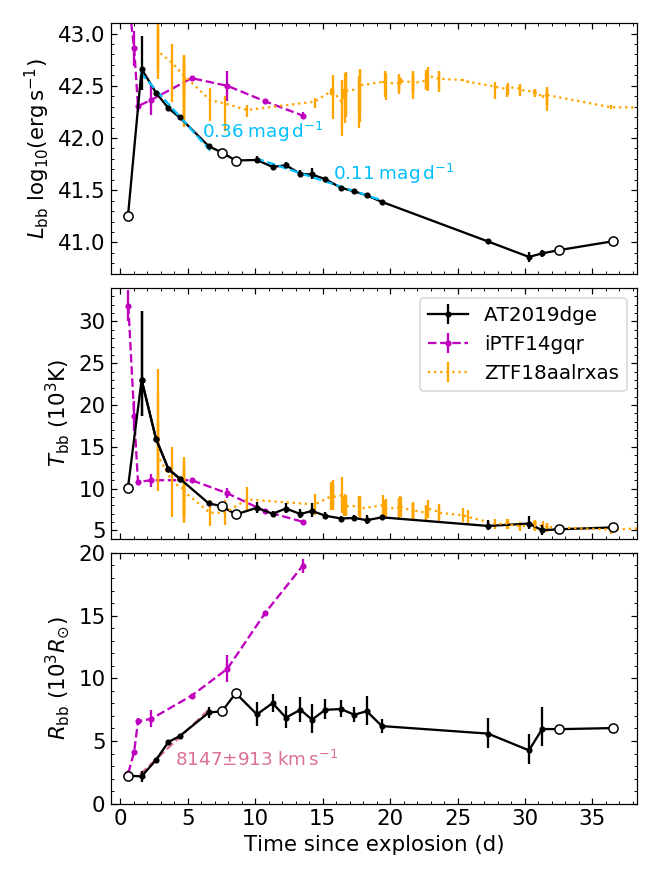

In [261]:
plt.figure(figsize=(6., 8))
ax0 = plt.subplot(311)
ax1 = plt.subplot(312)
ax2 = plt.subplot(313)

ax0.errorbar(trf[~ix_rough]+toff, lgLbbs[~ix_rough], [lgLbbs_uncl[~ix_rough], lgLbbs_uncr[~ix_rough]], fmt = ".k", zorder = 3)
ax0.plot(trf[ix_rough]+toff, lgLbbs[ix_rough], 'ko',  mfc='white', zorder = 3)
ax0.plot(trf+toff, lgLbbs, 'k-',  zorder = 2, label = "AT2019dge")
ax0.errorbar(t14, lgL14, lgL14_unc, fmt = '.--m', zorder = 1, label = "iPTF14gqr")
ax0.set_ylim(40.7, 43.1)
get_Lbol_decline_rate1(trf[~ix_rough]+toff, lgLbbs[~ix_rough], lgLbbs_unc[~ix_rough], ax0)
get_Lbol_decline_rate2(trf[~ix_rough]+toff, lgLbbs[~ix_rough], lgLbbs_unc[~ix_rough], ax0)
ax0.errorbar(t19, lgL19, [lgL19_uncr, lgL19_uncl], fmt = ":", color = "orange", label = "ZTF18aalrxas")

ax1.errorbar(trf[~ix_rough]+toff, Tbbs[~ix_rough]/1e+3, [Tbbs_uncl[~ix_rough]/1e+3, Tbbs_uncr[~ix_rough]/1e+3], fmt='.k', zorder = 3)
ax1.errorbar(trf[~ix_rough][:4]+toff, Tbbs[~ix_rough][:4]/1e+3, [Tbbs_uncl[~ix_rough][:4]/1e+3, Tbbs_uncr[~ix_rough][:4]/1e+3], fmt='.-k', zorder = 3, label = "AT2019dge")
ax1.plot(trf[ix_rough]+toff, Tbbs[ix_rough]/1e+3, 'ko',  mfc='white', zorder = 3)
ax1.plot(trf+toff, Tbbs/1e+3, 'k-', zorder = 2)
ax1.errorbar(t14, T14/1e+3, T14_unc/1e+3, fmt = '.--m', zorder = 1, label = "iPTF14gqr")
ax1.errorbar(t19, T19, T19_unc, fmt = ":", color = "orange", label = "ZTF18aalrxas")
ax1.set_ylim(4, 34)
ax1.legend(fontsize = fs-1)
    
ax2.errorbar(trf[~ix_rough]+toff, Rbbs[~ix_rough]/1e+3, [Rbbs_uncl[~ix_rough]/1e+3, Rbbs_uncr[~ix_rough]/1e+3], fmt='.k', zorder = 3)
ax2.plot(trf[ix_rough]+toff, Rbbs[ix_rough]/1e+3, 'ko',  mfc='white', zorder = 3)
ax2.plot(trf+toff, Rbbs/1e+3, 'k-', zorder = 2)
ax2.errorbar(t14, R14/1e+3, R14_unc/1e+3, fmt = '.--m', zorder = 1)
#ax2.errorbar(t19, R19, R19_unc, fmt = ":", color = "orange", label = "ZTF18aalrxas")
ax2.set_ylim(0, 20)

get_v_atpeak(trf+toff, Rbbs, Rbbs_unc, ax2)

get_refineaxis(ax0, ax1, ax2, toff)
plt.tight_layout(h_pad=0)
plt.savefig('../paper/figures/Tbb_Rbb.pdf')

In [148]:
%matplotlib notebook

Integrate energy?

In [204]:
from scipy.integrate import quad
from scipy.interpolate import interp1d

In [206]:
tt = trf+toff

In [210]:
func_lbb = interp1d(tt, Lbbs)
tt[0] + 0.1

0.6631499999988589

In [211]:
I = quad(func_lbb, 0.6, 30)

In [212]:
I[0]

2.0360586717785342e+43

### Compare with other Type Ibn

In [38]:
t_13ccw, lgL_13ccw = np.loadtxt("../data/otherSN/Pastorello2015c/LSQ13ccw", skiprows=1).T
ix = np.argsort(t_13ccw)
t_13ccw = t_13ccw[ix]
lgL_13ccw = lgL_13ccw[ix]

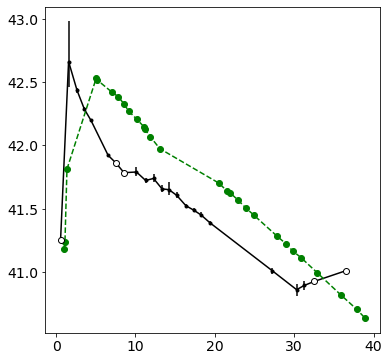

In [39]:
plt.figure(figsize=(6., 6))
ax0 = plt.subplot(111)
ax0.errorbar(trf[~ix_rough]+toff, lgLbbs[~ix_rough], [lgLbbs_uncl[~ix_rough], lgLbbs_uncr[~ix_rough]], fmt = ".k", zorder = 3)
ax0.plot(trf[ix_rough]+toff, lgLbbs[ix_rough], 'ko',  mfc='white', zorder = 3)
ax0.plot(trf+toff, lgLbbs, 'k-',  zorder = 2, label = "AT2019dge")
ax0.plot(t_13ccw, lgL_13ccw, 'go', label = "LSQ13ccw")
ax0.plot(t_13ccw, lgL_13ccw, 'g', linestyle = '--')
#ax.semilogy()